#  Approach 2: Content-Based Recommendation Engine

This appraoch will be similar to how sites without user information may recommend similar items based on item content (item descriptions, images, etc.). Because the data we have is a firm's description, we can perform some type of feature extraction and use a recommendation engine to recomend the most similar firms to it.

## Feature Extraction

For this approach, we will create the features by doing TF-IDF (Term Frequency - Inverse Document Frequency) to parse through the descriptions, identify distinct phrases in each item's description, and then find 'similar' products based on those phrases. In our case TF-IDF will work by looking at all one, two, and three-word phrases (uni-, bi-, and tri-grams) that appear multiple times in a description (the "term frequency") and divides them by the number of times those same phrases appear in all product descriptions. So terms that are 'more distinct' to a particular product get a higher score, and terms that appear often, but also appear often in other products get a lower score. Note: we will also drop all stop words (commom words like: the, we, a).

## Measuring Similar in the Recommender

Once the features are obtained, we will measure a similar firm with cosine similarity. We will do this by using SciKit Leanr's linear_kernel (which in this case is equivalent to cosine similarity).

In [17]:
#load modules
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as  np

# Pretty display for notebooks
%matplotlib inline

In [2]:
#functions to create recommender
def train(data_source):
    start = time.time()
    ds = pd.read_csv(data_source, usecols=["name", "desc"])
    print "Training data ingested in %s seconds." % (time.time() - start)
    start = time.time()
    frame=_train(ds)
    print "Engine trained in %s seconds." % (time.time() - start)
    return frame

def _train(ds):
    """
    Train the engine.
    Create a TF-IDF matrix of unigrams, bigrams, and trigrams
    for each firm. The 'stop_words' param tells the TF-IDF
    module to ignore common english words like 'the', etc.
    Then we compute similarity between all products using
    SciKit Leanr's linear_kernel (which in this case is
    equivalent to cosine similarity).
    Iterate through each item's similar items and store the
    10 most-similar. 
    Similarities and their scores are stored in 
    :param ds: A pandas dataset containing two fields: description & id
    """

    columns = ['name','content_recommended']
    frame = pd.DataFrame(columns=columns)
    
    tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 3),
                         min_df=0,
                         stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['desc'])

    cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

    for idx, row in ds.iterrows():
        similar_indices = cosine_similarities[idx].argsort()[:-11:-1]
        similar_items = [(cosine_similarities[idx][i], ds['name'][i])
                         for i in similar_indices]

        # First item is the item itself, set 0 as 1 to remove it.
        # This 'sum' is turns a list of tuples into a single tuple:
        # [(1,2), (3,4)] -> (1,2,3,4)
        flattened = sum(similar_items[0:], ())
        #add to frame
        arr=[row['name'], flattened]
        frame.loc[len(frame)]=arr
    return frame

In [3]:
#train, and create dataframe with 10 recommeneded firms
df=train('companies.csv')

Training data ingested in 0.287177801132 seconds.
Engine trained in 14.5276880264 seconds.


In [4]:
#see an example output of df
df.head()

,name,content_recommended
0,Octagen,"(1.0, Octagen, 0.146220312665, Flex Pharma, 0...."
1,GeckoGo,"(1.0, GeckoGo, 0.151951568267, Truth Soft, 0.1..."
2,Yantra,"(1.0, Yantra, 0.101971940085, Valdero, 0.08675..."
3,Insider Pages,"(1.0, Insider Pages, 0.064963935965, Xoova, 0...."
4,GrindMedia,"(1.0, GrindMedia, 0.145315243814, WinStar New ..."


In [5]:
#load original dataframe for checking performance
ds = pd.read_csv("companies.csv", usecols=["name", "desc"])

In [6]:
#functions to check performance 
def checker(firm_name):
    
    ind=df[(df.name==firm_name)].content_recommended[df[(df.name==firm_name)].index[0]]
    ind=ind[1::2] #take every other item in array
    print firm_name
    print ds[(ds.name==firm_name)].desc[ds[(ds.name==firm_name)].index[0]]
    print '===============Neighbors==============='
    for i in ind:
        print i
        print ds[(ds.name==i)].desc[ds[(ds.name==i)].index[0]]
        print '-----------------------------'

# Checking Performance

For this Problem, I implement three seperate models. Therefore to try and get both an understanding of which implementation may be superior and if an implementation even makes sense, I create a function that prints the name and description of a firm we want to look at then prints a list of the nearest firms and thier descriptions. The idea is to read about the other firms and see if they intuitively seem similar. 

For purpose of measuring performance across the three models, I have chosen three firms randomly: Octagen, Yantra, Disocvery Engine. In each implementation, we check performance on the same three companies. Ofocurse, you can check additional firms by running the "checker" function. 

Also, The discusion of the models' performances will be in the capstone project report under 'Results'.

In [7]:
#check Octagen
checker('Octagen')

Octagen
Operator of biopharmaceutical company. The company develops drugs for hemophilia, other genetic disorders and variations of recombinant B domain to avoid inactivation by flying below the radar screen of the immune system.
===============Neighbors===============
Octagen
Operator of biopharmaceutical company. The company develops drugs for hemophilia, other genetic disorders and variations of recombinant B domain to avoid inactivation by flying below the radar screen of the immune system.
-----------------------------
Flex Pharma
Operator of a biopharmaceutical company. The company develops clinically proven products and treatments for muscle cramps and spasms.
-----------------------------
Alkermes
Operator of a biopharmaceutical company. The company develops products based on drug-delivery technologies to enhance therapeutic outcomes in major diseases.
-----------------------------
Twinstrand Therapeutics
Operator of biopharmaceutical company. The company engages in the discove

In [8]:
#check Yantra
checker('Yantra')

Yantra
Provider of distributed order management and supply chain fulfillment solutions for retail, distribution, logistics, and manufacturing industries. The company focuses on distributed order management, supply collaboration, inventory synchronization, reverse logistics, logistics management, networked warehouse management, and delivery and service scheduling. It also provides consulting and support services. It offers Yantra 7x products, a comprehensive group of software applications, which enable organizations to manage their fulfillment processes across customers, operations, suppliers, and partners.
===============Neighbors===============
Yantra
Provider of distributed order management and supply chain fulfillment solutions for retail, distribution, logistics, and manufacturing industries. The company focuses on distributed order management, supply collaboration, inventory synchronization, reverse logistics, logistics management, networked warehouse management, and delivery and 

In [9]:
#check Discovery Engine
checker('Discovery Engine')

Discovery Engine
Developer of an internet search engine. The company offers an interaction model of search engine that also can also compile information from multiple sources.
===============Neighbors===============
Discovery Engine
Developer of an internet search engine. The company offers an interaction model of search engine that also can also compile information from multiple sources.
-----------------------------
Peryskop.pl
Provider of an online search engine. The company provides semantic search engine for products and product\'s reviews in Polish and English.
-----------------------------
JustSpotted
Provider of real time search engine. The company\'s search engine aggregates and organizes content being shared on the internet. It offers search options on entertainment, technology, sports, world and business, science, gaming, politics and lifestyle topics.
-----------------------------
Goshme Solucoes Para a Internet
Developer and provider of search engine. The company assists u

# Improving the Model

The model uses TF-IDF for feature extraction, leverages phrases as well as uni-grams, drops stop words, and uses a linear kernel to obtain cosine similairty instead of using a nearest neighbor search. Possible improvements are:

- Append the keyword list as a feature: possibly adding the keywords to the description both in phrase form and as uni-grams, then apply TF-IDF.
- Use a different method for feature extraction: some word vectorization (like word2vec)
- Mine more data: could create a webscraper with Selenium to collect more information about the firms; one thought is use crunchbase to get a competitor list. 

## Free-Form Visualization

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:

- Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
- Is the visualization thoroughly analyzed and discussed?
- If a plot is provided, are the axes, title, and datum clearly defined?

In [10]:
fr = pd.read_csv('companies.csv', usecols=["name", "desc"])
tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 3),
                         min_df=0,
                         stop_words='english')
tfidf_matrix = tf.fit_transform(fr['desc'])

In [12]:
feats=tfidf_matrix.toarray()

In [13]:
feats

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [18]:
#For high-dimensional sparse data it is helpful to first reduce the dimensions 
#to 50 dimensions with TruncatedSVD and then perform t-SNE. 
#This will usually improve the visualization.
#Takes over 20 mins
feats_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(feats)

In [20]:
feats_reduced

array([[ 0.03266583, -0.02877862, -0.07479648, ...,  0.00030522,
        -0.01021005, -0.00615002],
       [ 0.07830927,  0.06802107, -0.03533385, ...,  0.07303041,
         0.01329558,  0.05426497],
       [ 0.09668009, -0.04879605,  0.04798921, ..., -0.03157542,
         0.00554391, -0.01378309],
       ..., 
       [ 0.05443854,  0.0019519 ,  0.03495317, ..., -0.01129523,
         0.04102731,  0.00991003],
       [ 0.04600387, -0.02686194, -0.01701287, ...,  0.01918611,
        -0.01466037,  0.02760647],
       [ 0.08447673, -0.02942997,  0.00267864, ..., -0.00272445,
        -0.00326074, -0.02570336]])

In [21]:
#t-sne
feats2d = TSNE(n_components=2, random_state=0).fit_transform(feats_reduced) 

In [31]:
def plot(firm_name):
    plt.clf()
    names1=list(df['name'])
    #names=[n.encode('utf-8') for n in names]
    x1=[feats2d[i][0] for i in range(len(names1))]
    y1=[feats2d[i][1] for i in range(len(names1))]
    #nn=df[(df.name==firm_name)].nearest_neighbor[df[(df.name==firm_name)].index[0]]
    ind=df[(df.name==firm_name)].content_recommended[df[(df.name==firm_name)].index[0]]
    ind=ind[1::2] #take every other item in array
   
    
    x=[]
    y=[]
    names=[]
    
    for n in ind:
        for i, name in enumerate(names1):
            if n==name:
                names.append(name)
                x.append(x1[i])
                y.append(y1[i])  
                
                
    #ploat scatter plot
    plt.scatter(x1,y1,color='yellow')
    plt.scatter(x,y,color='green')
    
    for i, name in enumerate(names):
        try:
            plt.annotate(name, (x[i],y[i]))
        except:
            print 'name'

    #make titles
    plt.title("t-sne plot")
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.show

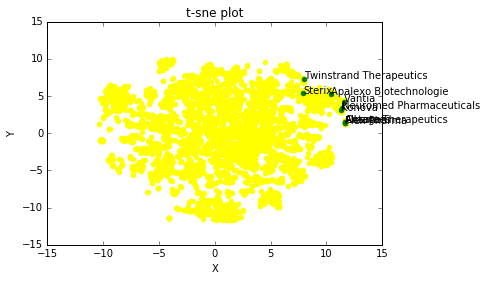

In [32]:
#t-sne doesn't look very good
plot('Octagen')

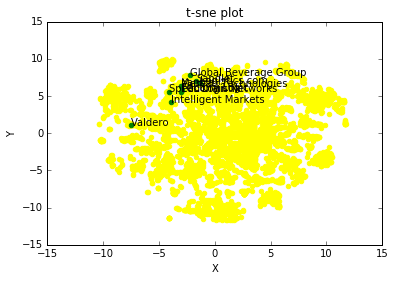

In [33]:
#t-sne doesn't look very good
plot('Yantra')

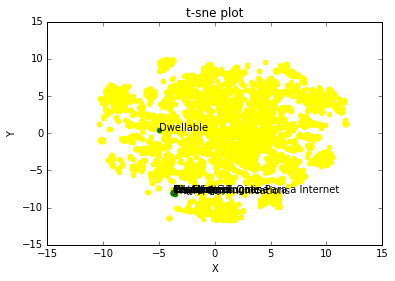

In [34]:
#t-sne doesn't look very good
plot('Discovery Engine')